In [1]:
import pandas as pd
import numpy as np

In [3]:
# anime = pd.read_csv('./anime.csv')
# ratings = pd.read_csv('rating_complete.csv')
# watching = pd.read_csv('watching_status.csv')
# animeSynopsis = pd.read_csv('anime_with_synopsis.csv')
animeListFull = pd.read_csv('./animelist.csv')

In [4]:
len( animeListFull.anime_id.unique() )

17562

In [12]:
animeList = animeListFull[['user_id','anime_id','rating']]
prev= (len(animeList.user_id.unique()))
nRatings = animeList.user_id.value_counts()
animeList = animeList[animeList['user_id'].isin(nRatings[nRatings>=200].index)].copy()
new = len(animeList.user_id.unique())
print(new/prev)

0.5414986033090831


In [13]:
minRating = min(animeList.rating)
maxRating = max(animeList.rating)
print(minRating,maxRating)
animeList.rating = animeList.rating.apply(lambda x: x/maxRating)
avgRating = np.mean(animeList.rating)

0 10


In [14]:
duplicates = animeList.duplicated()
if duplicates.sum()>0:
    print('> {} duplicates'.format(duplicates.sum()))
    animeList = animeList[~duplicates]
print('> {} duplicates'.format(animeList.duplicated().sum()))

> 1 duplicates
> 0 duplicates


In [ ]:
g = animeList.groupby('user_id')['rating'].count()
print(g)
topUsers = g.dropna().sort_values(ascending=False)[:20]
topR = animeList.join(topUsers, rsuffix='_r', how='inner', on='user_id')

g = animeList.groupby('anime_id')['rating'].count()
print(g)
topAnime = g.dropna().sort_values(ascending=False)[:20]
topR = animeList.join(topAnime, rsuffix='_r', how='inner', on='anime_id')

topR.dropna(inplace=True)


In [15]:
userIds = animeList.user_id.unique().tolist()
user2userEncoded = {x: i for i, x in enumerate(userIds)}
userEncoded2User = {i: x for i, x in enumerate(userIds)}
animeList['user'] = animeList.user_id.map(user2userEncoded)
nUsers = len(user2userEncoded)

animeIds = animeList.anime_id.unique().tolist()
anime2animeEncoded = {x: i for i, x in enumerate(animeIds)}
animeEncoded2Anime = {i: x for i, x in enumerate(animeIds)}
animeList['anime'] = animeList.anime_id.map(anime2animeEncoded)
nAnimes= len(anime2animeEncoded)

print("Num of users: {}, Num of animes: {}".format(nUsers, nAnimes))
print("Min rating: {}, Max rating: {}".format(min(animeList['rating']), max(animeList['rating'])))

Num of users: 176404, Num of animes: 17562
Min rating: 0.0, Max rating: 1.0


In [32]:
animeList = animeList.sample(frac=1, random_state=2)
X = animeList[['user','anime']].values
y = animeList['rating']

In [33]:
testSize= 100000
trainIndicies = animeList.shape[0] - testSize
xtrain, xtest, ytrain, ytest = (X[:trainIndicies],X[trainIndicies:],y[:trainIndicies],y[trainIndicies:])
print('Train set ratings:{}'.format(len(ytrain)))
print('Test set ratings:{}'.format(len(ytest)))
xTrainArray = [xtrain[:, 0], xtrain[:,1]]
xTestArray = [xtest[:, 0], xtest[:,1]]

Train set ratings:10393719
Test set ratings:100000


In [17]:
import keras
from keras import layers 
from keras.models import Model

from keras.layers import Add, Activation, Lambda, BatchNormalization, Concatenate, Dropout, Input, Embedding, Dot, Reshape, Dense, Flatten

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)

Num GPUs Available:  0
2.7.0


In [18]:
def RecommenderNet():
    embedding_size = 64
    
    user = Input(name = 'user', shape = [1])
    user_embedding = Embedding(name = 'user_embedding',
                       input_dim = nUsers, 
                       output_dim = embedding_size)(user)
    
    anime = Input(name = 'anime', shape = [1])
    anime_embedding = Embedding(name = 'anime_embedding',
                       input_dim = nAnimes, 
                       output_dim = embedding_size)(anime)
    
    #x = Concatenate()([user_embedding, anime_embedding])
    x = Dot(name = 'dot_product', normalize = True, axes = 2)([user_embedding, anime_embedding])
    x = Flatten()(x)
        
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs=[user, anime], outputs=x)
    model.compile(loss='binary_crossentropy', metrics=["mae", "mse"], optimizer='Adam')
    
    return model

model = RecommenderNet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 anime (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 64)        11289856    ['user[0][0]']                   
                                                                                                  
 anime_embedding (Embedding)    (None, 1, 64)        1123968     ['anime[0][0]']                  
                                                                                              

2022-08-11 15:01:51.743350: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau

In [20]:
start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005
batch_size = 10000

rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
    if epoch<rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return  (max_lr - min_lr) * exp_decay ** (epoch - rampup_epochs - sustain_epochs) + min_lr

lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=0)
checkpointPath = './weights.h5'
model_checkpoints = ModelCheckpoint(filepath=checkpointPath, save_weights_only=True, monitor='val_loss', mode='min', save_best_only = True)
early_stopping = EarlyStopping(patience=3, monitor='val_loss', mode='min', restore_best_weights=True)

callbacks = [model_checkpoints, lr_callback, early_stopping]

In [22]:

hist = model.fit(x=xTrainArray, y=ytrain, batch_size=batch_size, epochs=20, verbose=1, validation_data=(xTestArray, ytest), callbacks = callbacks)
model.load_weights(checkpointPath)

Epoch 1/20
3419/4222 [=======================>......] - ETA: 12s - loss: 0.8009 - mae: 0.3862 - mse: 0.2004

KeyboardInterrupt: 

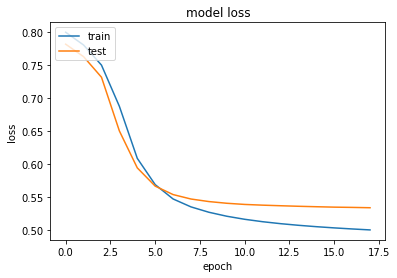

In [93]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(hist.history["loss"][0:-2])
plt.plot(hist.history["val_loss"][0:-2])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [21]:
def extractWeights(name, model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights/np.linalg.norm(weights, axis=1).reshape((-1,1))
    return weights
anime_weights = extractWeights('anime_embedding', model)
user_weights = extractWeights('user_embedding', model)

model = tf.keras.models.load_model('animeListModel/')

In [22]:
df = pd.read_csv('./anime.csv')

df.replace("Unkown", np.nan, inplace=True)

def getAnimeName(animeId):
    try:
        name = df[df.anime_id == animeId].eng_version.values[0]
        if name is np.nan or name == "Unknown":
            name = df[df.anime_id == animeId].Name.values[0]
    except:
        print('err')
    return name

In [24]:
df['anime_id'] = df['MAL_ID']
df['eng_version'] = df['English name']
df['eng_version'] = df.anime_id.apply(lambda x: getAnimeName(x))

df.sort_values(by=['Score'],inplace=True, ascending=False, kind='quicksort', na_position='last')
df = df[['anime_id','eng_version','Score','Genres','Episodes','Type','Premiered','Members']]

In [ ]:
getSynopsis('Ex-Arm')

"2014: Akira Natsume seems to almost have a phobia of electrical devices while also being very good at diagnosing them. He resolves to change himself for the better and get a girlfriend like his older brother did. ...But then Akira suddenly dies in an accident. 16 years later a special policewoman and her android partner retrieve and activate a highly advanced AI and superweapon called EX-ARM and put it into full control of their ship as a last resort. Turns out the AI is actually just Akira's brain! (Source: MU)"

In [25]:
def getAnimeFrame(anime):
    if isinstance(anime,int):
        return df[df.anime_id == anime]
    if isinstance(anime,str):
        return df[df.eng_version == anime]

def getSynopsis(anime):
    try:
        if isinstance(anime, int):
            return synopsisDf[synopsisDf.MAL_ID == anime].Synopsis.iloc[0]
        if isinstance(anime, str):
            return synopsisDf[synopsisDf.Name == anime].Synopsis.iloc[0]
    except:
        print('no synopsis')
        return ''

In [26]:
synopsisDf = pd.read_csv('anime_with_synopsis.csv') 
synopsisDf = synopsisDf[['MAL_ID','Name','Score','Genres','sypnopsis']]

synopsisDf.rename(columns={'sypnopsis':'Synopsis'}, inplace=True)

In [27]:
pd.set_option('max_colwidth', None)
def findSimilarAnimes(name, n=10, return_dist=False, neg=False):
        index =getAnimeFrame(name).anime_id.values[0]
        encoded_index = anime2animeEncoded.get(index)
        weights = anime_weights
        dists=np.dot(weights, weights[encoded_index])
        sortedDists = np.argsort(dists)
        n = n+1
        print(sortedDists)
        if neg:
            closest = sortedDists[:n]
        else:
            closest = sortedDists[-n:]
        print('animes closest to {}'.format(name))
        if return_dist:
            return dists,closest
        
        rindex = df
        SimilarityArr = []
        print((closest))
        for close in closest:
            decoded_id = animeEncoded2Anime.get(close)
            synopsis = getSynopsis(decoded_id)
            animeFrame = getAnimeFrame(decoded_id)
            animeName = animeFrame.eng_version.values[0]
            genre = animeFrame.Genres.values[0]
            similarity = dists[close]
            SimilarityArr.append({'id': decoded_id, "name": animeName, 
                                  "similarity": similarity, 
                                  "genre": genre,"synopsis": synopsis})
        Frame = pd.DataFrame(SimilarityArr).sort_values(by='similarity', ascending=False)
        return Frame

In [28]:
findSimilarAnimes('Dragon Ball Z', n=5, neg=False)

[16841  9711 13931 ...  6534 12952  1351]
animes closest to Dragon Ball Z
[17104  9078  6670  6534 12952  1351]


,id,name,similarity,genre,synopsis
5,813,Dragon Ball Z,1.000000,"Action, Adventure, Comedy, Fantasy, Martial Arts, Shounen, Super Power","Five years after winning the World Martial Arts tournament, Gokuu is now living a peaceful life with his wife and son. This changes, however, with the arrival of a mysterious enemy named Raditz who presents himself as Gokuu's long-lost brother. He reveals that Gokuu is a warrior from the once powerful but now virtually extinct Saiyan race, whose homeworld was completely annihilated. When he was sent to Earth as a baby, Gokuu's sole purpose was to conquer and destroy the planet; but after suffering amnesia from a head injury, his violent and savage nature changed, and instead was raised as a kind and well-mannered boy, now fighting to protect others. With his failed attempt at forcibly recruiting Gokuu as an ally, Raditz warns Gokuu's friends of a new threat that's rapidly approaching Earth—one that could plunge Earth into an intergalactic conflict and cause the heavens themselves to shake. A war will be fought over the seven mystical dragon balls, and only the strongest will survive in Dragon Ball Z ."
4,17221,Shin Kabukichou Story Hana no Asukagumi!,0.451260,"Adventure, Drama, Shoujo",Based on the popular girl's manga Hana no Asukagumi! (The Glorious Asuka Gang!) by Takaguchi Satosumi.
3,1777,The Weathering Continent,0.449631,"Action, Adventure, Fantasy, Supernatural","Three adventurers—a warrior, a priest, and a young woman—traverse a land devastated by centuries of environmental calamities searching only for a way to survive. In their journeys they stumble across first the remains of a band of desperate treasure-hunters, and then the treasure they were seeking: Azec Sistra, the legendary City of the Dead. Unfortunately, the bandits responsible for slaughtering the treasure-hunters have also found their way to the city, but more worrisome still are the guardians which protect Azec Sistra from those who would violate the spirits at rest there... (Source: ANN)"
2,36215,One Piece: Episode of East Blue - Luffy to 4-nin no Nakama no Daibouken,0.445117,"Action, Adventure, Comedy, Super Power, Drama, Fantasy, Shounen","The words that Gold Roger, the King of the Pirates, uttered just before his death excited the masses and the world has entered a Great Pirate Era! There is a group of young pirates who are about to set sail on the Grand Line. Monkey D. Luffy, a rubber man. Roronoa Zoro aka “Pirate Hunter.” Usopp, a sniper. Sanji, a seafaring cook. And “Cat Burglar” Nami. They, the Straw Hats, all place a foot upon a barrel and make their vows before their next journey across the great ocean. Luffy shouts “In order to be the King of the Pirates!” A decade ago in the Windmill Village... A little boy Luffy was enthralled with a pirate boss Red-Haired Shanks. But a group of mountain bandits shows up and makes fun of the pirates. “Why didn't you fight them?!” Luffy yells out angrily but Shanks says that it's nothing worth getting mad over. At that time, Luffy snatches the Gum-Gum Fruit from a treasure box and eats it and as a result, his entire body becomes rubber and he loses the ability to swim for the rest of his life! A few days later, Luffy is surrounded by the mountain bandits again and Shanks comes to help. “No matter what the reason, anyone who hurts my friends has to pay!!” Shanks and his pirate crew are incredibly strong and they beat down the mountain bandits. Higuma, the head of the mountain bandits, runs away kidnapping Luffy and heads for the sea. However, they encounter a local Sea Monster there and are attacked. Luffy is in a desperate situation... But again, Shanks saves the day. He outstares the Sea Monster and chases it away but in exchange, he loses his left arm... When Shanks leaves the village, he leaves his straw hat with Luffy. “Come bring it back to me someday! Once you've become a great pirate!” 10 years later, Luffy has grown up strong and he sets out for an adventure on a sma